In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from qdrant_client import QdrantClient, models
from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi
import re
import tiktoken
import pandas as pd
import json
from collections import defaultdict

/Users/sethurama/DEV/LM/book-mate/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def strip_gutenberg(text: str) -> str:
    start_match = re.search(r"\*\*\* START OF.*\*\*\*", text)
    end_match = re.search(r"\*\*\* END OF.*\*\*\*", text)
    if start_match and end_match:
        return text[start_match.end(): end_match.start()]
    return text


def read_book(book_fp="../DATA/alice_in_wonderland.txt"):

    book_path = Path(book_fp)
    raw_text = book_path.read_text(encoding="utf-8")

    clean_text = strip_gutenberg(raw_text)
    print("Clean word count:", len(clean_text.split()))
    return clean_text

In [3]:

enc = tiktoken.get_encoding('cl100k_base')

SPLIT_PATTERN = r"^(?:CHAPTER [IVXLCDM]+\.)\s*\n"

def split_sections(text: str):
    return re.split(SPLIT_PATTERN, text, flags=re.IGNORECASE | re.MULTILINE)

def chunk_tokens(text: str, max_tokens=1000, overlap=100):
    tokens = enc.encode(text)
    chunks = []
    for i in range(0, len(tokens), max_tokens - overlap):
        chunk = enc.decode(tokens[i:i+max_tokens])
        chunks.append(chunk)
    return chunks

def hybrid_chunk(text: str, max_tokens=1000, overlap=100):
    sections = split_sections(text=text)
    all_chunks = []
    for idx, section in enumerate(sections): 
        section_chunks = chunk_tokens(section, max_tokens, overlap)
        for cid, sub in enumerate(section_chunks):
            all_chunks.append(
                {
                    "section": idx+1,
                    "chunk_id": f"{idx+1}_{cid+1}",
                    "text": sub,
                    "n_tokens": len(enc.encode(sub)),
                    "char_len": len(sub)
                }
            )

    return all_chunks

In [4]:
text = read_book()
chunks = hybrid_chunk(text, max_tokens=800, overlap=100)

print("Num chunks:", len(chunks))
print("Preview:", chunks[10]["text"][:300])


Clean word count: 26525
Num chunks: 61
Preview:  the
birds and animals that had fallen into it: there were a Duck and a
Dodo, a Lory and an Eaglet, and several other curious creatures. Alice
led the way, and the whole party swam to the shore.







In [5]:
df = pd.DataFrame(chunks, columns=['section', 'chunk_id', 'text', 'n_tokens', 'char_len'])
df.head()

,section,chunk_id,text,n_tokens,char_len
0,1,1_1,\n\n[Illustration]\n\n\n\n\nAlice’s Adventures...,159,586
1,2,2_1,Down the Rabbit-Hole\n\n\nAlice was beginning ...,800,3282
2,2,2_2,"thousand miles down, I think—” (for, you see,...",800,3069
3,2,2_3,"herself in a long, low hall, which was lit up ...",800,3200
4,2,2_4,", in fact, a sort of mixed\nflavour of cherry-...",784,3169


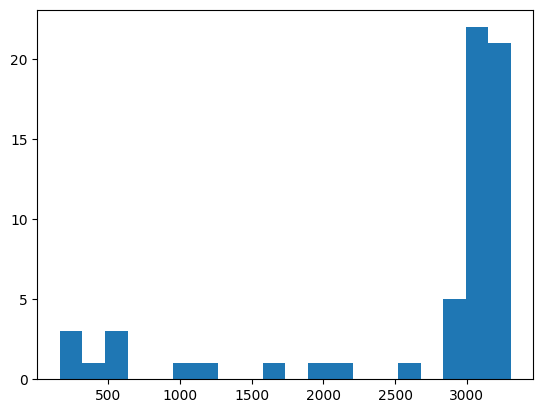

In [6]:
plt.hist(df['char_len'], bins=20)
plt.show()

In [7]:
# Prepare embeddings

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def embed_batch(chunks):
    texts = [c["text"] for c in chunks]
    vecs = embedder.encode(texts, normalize_embeddings=True).tolist()
    return vecs

vectors = embed_batch(chunks)
print("Vector shape:", len(vectors), len(vectors[0]))


Vector shape: 61 384


### Baseline: keyword search with BM25


In [8]:

tokenized = [c["text"].split() for c in chunks]
bm25 = BM25Okapi(tokenized)

def bm25_search(query, topk=5):
    scores = bm25.get_scores(query.split())
    ranked = sorted(enumerate(scores), key=lambda x: -x[1])[:topk]
    return [(chunks[i], s) for i, s in ranked]

# SEARCH_QUERY = "Elizabeth Bennet"
SEARCH_QUERY = "White Rabbit"
for res, score in bm25_search(SEARCH_QUERY):
    print(f">> {res["chunk_id"]} (score: {score:.3f}):\n", res["text"][:200], "..\n")

>> 13_2 (score: 3.692):
  the Queen.

“Well, I shan’t go, at any rate,” said Alice: “besides, that’s not a
regular rule: you invented it just now.”

“It’s the oldest rule in the book,” said the King.

“Then it ought to be Num ..

>> 12_4 (score: 3.664):
 Then you may _sit_ down,” the King replied.

Here the other guinea-pig cheered, and was suppressed.

“Come, that finished the guinea-pigs!” thought Alice. “Now we shall get
on better.”

“I’d rather fi ..

>> 12_2 (score: 3.239):
 at all what had become of it; so, after hunting all about for it, he
was obliged to write with one finger for the rest of the day; and this
was of very little use, as it left no mark on the slate.

“H ..

>> 12_1 (score: 3.214):
 Who Stole the Tarts?


The King and Queen of Hearts were seated on their throne when they
arrived, with a great crowd assembled about them—all sorts of little
birds and beasts, as well as the whole pa ..

>> 9_3 (score: 2.870):
  roared the Queen, and Alice joined the procession,
wond

### Eval

In [9]:
# Golden dataset 

aiw_gt = []
with open("../DATA/GT/aiw.json", "r") as f:
    res = json.load(f)

    for cid, queries in res.items():
        for q in queries:
            aiw_gt.append(
                {
                    'gold_id': cid,
                    'query': q
                }
            )

# Eval Utils

def hit_rate_at_k(res_ids, gold_id, k=5):
    return 1.0 if gold_id in res_ids[:k] else 0.0


def mrr_at_k(res_ids, gold_id, k=5):
    for i, res_id in enumerate(res_ids[:k], start=1):
        if res_id == gold_id:
            return 1.0 / i 
    return 0.0


def calculate_metrics(results, k_values=[5, 7]):

    if not results:
        return {f"hit_rate_at_{k}": 0.0 for k in k_values} | {f"mrr_at_{k}": 0.0 for k in k_values}
    
    metrics = defaultdict(list)

    for result in results:
        res_ids = result.get('chunk_ids')
        gold_id = result.get('gold_id')

        for k in k_values:
            metrics[f'hit_rate_at_{k}'].append(hit_rate_at_k(res_ids, gold_id, k))
            metrics[f'mrr_at_{k}'].append(mrr_at_k(res_ids, gold_id, k))

    avg_metrics = {}
    for metric, values in metrics.items():
        avg_metrics[metric] = sum(values) / len(values) if values else 0.0

    avg_metrics['total_queries'] = len(results)

    return avg_metrics
    


In [10]:
aiw_gt[:10]

[{'gold_id': '1_1', 'query': 'Mad Tea-Party'},
 {'gold_id': '1_1', 'query': 'What happens in the Chapter IX?'},
 {'gold_id': '1_1', 'query': "Alice's encounters with characters"},
 {'gold_id': '1_1', 'query': 'Who is the Caterpillar?'},
 {'gold_id': '1_1', 'query': "What does Alice's journey symbolize?"},
 {'gold_id': '2_1', 'query': 'falling down the rabbit-hole'},
 {'gold_id': '2_1',
  'query': 'What does Alice think of the book without pictures?'},
 {'gold_id': '2_1', 'query': 'curtseying while falling'},
 {'gold_id': '2_1', 'query': 'Who does Alice see that makes her curious?'},
 {'gold_id': '2_1',
  'query': "What does Alice's curiosity reveal about her character?"}]

#### Test bm25 metrics

In [11]:


def evaluate(search_method):
    results = []
    for item in aiw_gt:
        gold_id = item['gold_id']
        query = item['query']

        res = search_method(query)
        results.append(
            {
                'gold_id': gold_id,
                'chunk_ids': res
            }
        )
    metrics = calculate_metrics(results)
    return metrics



In [12]:
# Return search ids only for BM25
def bm25_search_ids(query: str, topk=7):
    search_results = bm25_search(query, topk)
    return[c['chunk_id'] for c, score in search_results]

eval_res = evaluate(bm25_search_ids)
print(json.dumps(eval_res, indent=2))

{
  "hit_rate_at_5": 0.49361702127659574,
  "mrr_at_5": 0.32666666666666666,
  "hit_rate_at_7": 0.5404255319148936,
  "mrr_at_7": 0.33396149949341436,
  "total_queries": 235
}


### Semantic Search with Qdrant Vector DB

In [13]:
# Ensure Qdrant is running with docker-compose 

COLLECTION = "book_chunks"
qdrant = QdrantClient("localhost", port=6333)

if not qdrant.collection_exists(COLLECTION):
    qdrant.create_collection(
        collection_name=COLLECTION,
        vectors_config=models.VectorParams(
            size=len(vectors[0]),
            distance=models.Distance.COSINE
        )
    )

# Upsert points
qdrant.upsert(
    collection_name=COLLECTION,
    points=[
        models.PointStruct(
            id=i,
            vector=vectors[i],
            payload=chunks[i]
        )
        for i in range(len(chunks))
    ]
)

print(f" ## Inserted: {len(chunks)} chunks into Qdrant")

 ## Inserted: 61 chunks into Qdrant


/var/folders/9j/dq11054j6sg0m5lt67ct6fr40000gq/T/ipykernel_33922/2035202958.py:4: UserWarning: Qdrant client version 1.15.1 is incompatible with server version 1.8.3. Major versions should match and minor version difference must not exceed 1. Set check_compatibility=False to skip version check.
  qdrant = QdrantClient("localhost", port=6333)


In [14]:
# Embedding search with Qdrant 
def semantic_search(query, topk=7):
    vec = embedder.encode([query], normalize_embeddings=True)[0].tolist()
    hits = qdrant.search(collection_name=COLLECTION, query_vector=vec, limit=topk)
    return [(h.payload, h.score) for h in hits]

print("Semantic Results for 'Elizabeth Bennet':")
for res, score in semantic_search("Elizabeth Bennet"):
    print(f">> {res["chunk_id"]} (score): {score}\n", res["text"][:200], "..\n")


Semantic Results for 'Elizabeth Bennet':
>> 13_2 (score): 0.2578072
  the Queen.

“Well, I shan’t go, at any rate,” said Alice: “besides, that’s not a
regular rule: you invented it just now.”

“It’s the oldest rule in the book,” said the King.

“Then it ought to be Num ..

>> 10_3 (score): 0.24818961
  had to leave off being arches to do this, so
that by the end of half an hour or so there were no arches left, and
all the players, except the King, the Queen, and Alice, were in custody
and under sen ..

>> 12_3 (score): 0.23283276
 ,” said the Dormouse.

“Don’t talk nonsense,” said Alice more boldly: “you know you’re growing
too.”

“Yes, but _I_ grow at a reasonable pace,” said the Dormouse: “not in
that ridiculous fashion.” And ..

>> 2_5 (score): 0.22509444
  of expecting nothing but out-of-the-way
things to happen, that it seemed quite dull and stupid for life to go
on in the common way.

So she set to work, and very soon finished off the cake.

*      * ..

>> 9_3 (score): 0.2239375

/var/folders/9j/dq11054j6sg0m5lt67ct6fr40000gq/T/ipykernel_33922/196245737.py:4: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = qdrant.search(collection_name=COLLECTION, query_vector=vec, limit=topk)


In [15]:
# Return search ids only for BM25
def semantic_search_ids(query: str, topk=7):
    search_results = semantic_search(query, topk)
    return[c['chunk_id'] for c, score in search_results]

eval_res = evaluate(semantic_search_ids)
print(json.dumps(eval_res, indent=2))

/var/folders/9j/dq11054j6sg0m5lt67ct6fr40000gq/T/ipykernel_33922/196245737.py:4: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = qdrant.search(collection_name=COLLECTION, query_vector=vec, limit=topk)


{
  "hit_rate_at_5": 0.33191489361702126,
  "mrr_at_5": 0.2027659574468085,
  "hit_rate_at_7": 0.42127659574468085,
  "mrr_at_7": 0.2165450861195542,
  "total_queries": 235
}


In [16]:
# RRF Fusion 

def rrf_fusion(bm25_results, embed_results, k=7, c=60):
    """
    Fuse BM25 + Embedding rankings using Reciprocal Rank Fusion (RRF).
    
    Returns:
        list of chunk_ids (top-k fused)
    """
    ranks = defaultdict(float)

    # BM25 contribution
    for rank, (chunk, _) in enumerate(bm25_results, start=1):
        ranks[chunk["chunk_id"]] += 1.0 / (c + rank)

    # Embedding contribution
    for rank, (chunk, _) in enumerate(embed_results, start=1):
        ranks[chunk["chunk_id"]] += 1.0 / (c + rank)

    # Sort by fused score
    fused = sorted(ranks.items(), key=lambda x: -x[1])[:k]
    return [cid for cid, _ in fused]


In [18]:
def rrf_search_ids(query: str, topk=7):
    bm25_results = bm25_search(query, topk * 2)   
    embed_results = semantic_search(query, topk * 2) 
    return rrf_fusion(bm25_results, embed_results, k=topk)


In [19]:
eval_bm25 = evaluate(lambda q: [c["chunk_id"] for c, s in bm25_search(q, 7)])
eval_embed = evaluate(lambda q: [c["chunk_id"] for c, s in semantic_search(q, 7)])
eval_rrf   = evaluate(rrf_search_ids)

print("BM25:", json.dumps(eval_bm25, indent=2))
print("Semantic:", json.dumps(eval_embed, indent=2))
print("Hybrid RRF:", json.dumps(eval_rrf, indent=2))

/var/folders/9j/dq11054j6sg0m5lt67ct6fr40000gq/T/ipykernel_33922/196245737.py:4: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = qdrant.search(collection_name=COLLECTION, query_vector=vec, limit=topk)


BM25: {
  "hit_rate_at_5": 0.49361702127659574,
  "mrr_at_5": 0.32666666666666666,
  "hit_rate_at_7": 0.5404255319148936,
  "mrr_at_7": 0.33396149949341436,
  "total_queries": 235
}
Semantic: {
  "hit_rate_at_5": 0.33191489361702126,
  "mrr_at_5": 0.2027659574468085,
  "hit_rate_at_7": 0.42127659574468085,
  "mrr_at_7": 0.2165450861195542,
  "total_queries": 235
}
Hybrid RRF: {
  "hit_rate_at_5": 0.48936170212765956,
  "mrr_at_5": 0.28652482269503543,
  "hit_rate_at_7": 0.5872340425531914,
  "mrr_at_7": 0.3016210739614995,
  "total_queries": 235
}


In [21]:
def get_negatives(search_method, k=7):
    negatives = []
    for item in aiw_gt:
        gold_id = item['gold_id']
        query = item['query']
        res_ids = search_method(query)

        if gold_id not in res_ids[:k]:
            negatives.append({
                "query": query,
                "gold_id": gold_id,
                "retrieved": res_ids
            })
    return negatives

negatives_rrf = get_negatives(rrf_search_ids, k=7)
print(f"RRF negatives: {len(negatives_rrf)} / {len(aiw_gt)}")
print("Sample negative:", json.dumps(negatives_rrf[0:5], indent=2))


/var/folders/9j/dq11054j6sg0m5lt67ct6fr40000gq/T/ipykernel_33922/196245737.py:4: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  hits = qdrant.search(collection_name=COLLECTION, query_vector=vec, limit=topk)


RRF negatives: 97 / 235
Sample negative: [
  {
    "query": "Alice's encounters with characters",
    "gold_id": "1_1",
    "retrieved": [
      "13_4",
      "9_3",
      "9_5",
      "3_3",
      "8_5",
      "4_1",
      "13_5"
    ]
  },
  {
    "query": "What does Alice wish for with the key?",
    "gold_id": "2_2",
    "retrieved": [
      "8_4",
      "9_4",
      "12_1",
      "5_2",
      "8_3",
      "6_2",
      "13_4"
    ]
  },
  {
    "query": "bottle with 'DRINK ME' label",
    "gold_id": "2_2",
    "retrieved": [
      "5_2",
      "5_1",
      "2_3",
      "10_1",
      "5_6",
      "4_1",
      "8_1"
    ]
  },
  {
    "query": "Who is Dinah?",
    "gold_id": "2_2",
    "retrieved": [
      "11_4",
      "3_2",
      "3_4",
      "5_4",
      "12_1",
      "4_3",
      "4_2"
    ]
  },
  {
    "query": "What does Alice's wish to be smaller symbolize?",
    "gold_id": "2_2",
    "retrieved": [
      "3_3",
      "4_3",
      "5_2",
      "6_5",
      "10_1",
      "13_